The purpose of this notebook is to run some basic sanity checks on the raw data we collected

In [1]:
import pandas as pd

# Dune data: MKR burned (= interest paid)

Quick look at records and data types

In [2]:
dune_mkr_burned = pd.read_json('raw_files/dune_data.json')
display(dune_mkr_burned.head())
display(dune_mkr_burned.dtypes)

,debt_payment,date_trunc,usd_fee_paid,mkr_burned
0,10.000000,2017-12-18T00:00:00Z,0.000006,5.314251e-09
1,35367.482980,2017-12-19T00:00:00Z,0.455885,3.614891e-04
2,501412.750000,2017-12-20T00:00:00Z,0.178879,1.392923e-04
3,49782.711992,2017-12-21T00:00:00Z,1.158909,9.528478e-04
4,723915.309687,2017-12-22T00:00:00Z,19.756468,1.956660e-02


debt_payment    float64
date_trunc       object
usd_fee_paid    float64
mkr_burned      float64
dtype: object

Set the index as the date

In [3]:
dune_mkr_burned.set_index(pd.to_datetime(dune_mkr_burned['date_trunc']).dt.date, 
                          verify_integrity=True,
                          inplace=True                          
                         )

## Sanity check: MKR price
We compute the average price of MKR from the amount of MKR burned and the total USD value of those MKR as recorded in the Dune dataset. We then compare that average price with a chart from coinmarketcap

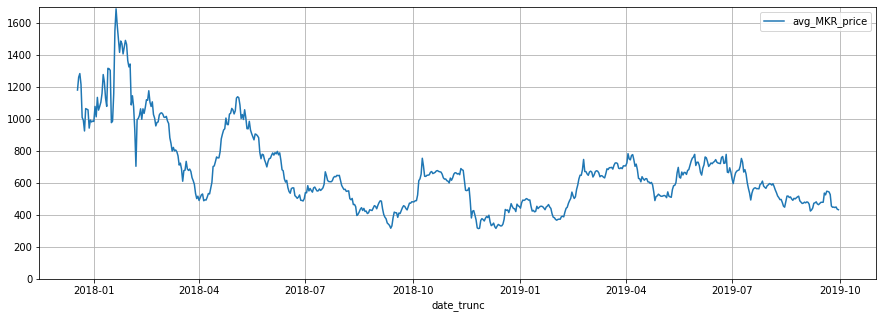

In [4]:
dune_mkr_burned['avg_MKR_price'] = dune_mkr_burned['usd_fee_paid'] / dune_mkr_burned['mkr_burned']
dune_mkr_burned.plot(y='avg_MKR_price', ylim=(0,1700), figsize=(15,5), grid=True)

Coinmarketcap chart for the price of MKR
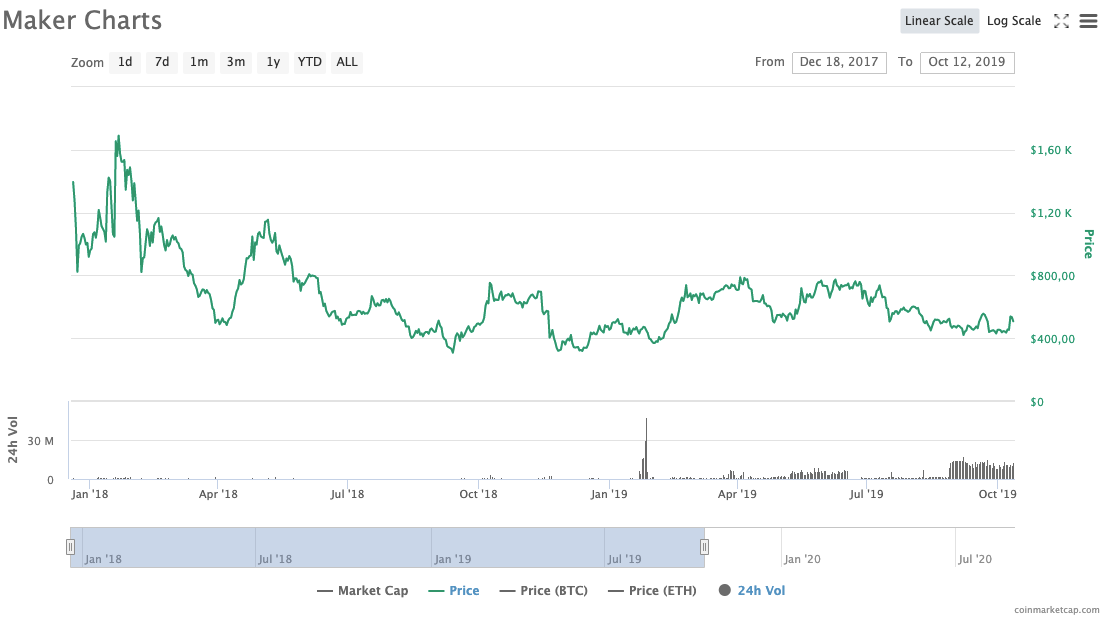

## Sanity check: MKR burned
We compute the cumulative amount of MKR burned and compare to a chart from makerburn.com

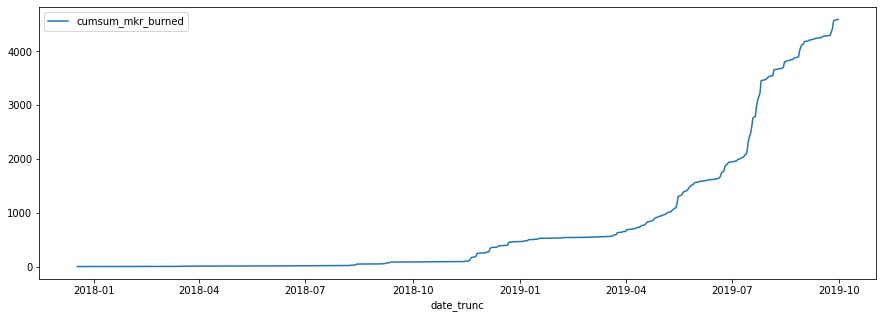

In [5]:
dune_mkr_burned['cumsum_mkr_burned'] = dune_mkr_burned['mkr_burned'].cumsum()
dune_mkr_burned.plot(y='cumsum_mkr_burned', figsize=(15,5))

Makerburn chart (y axis not displayed correctly, but if you hover over the chart on the website the amounts appoximately match)
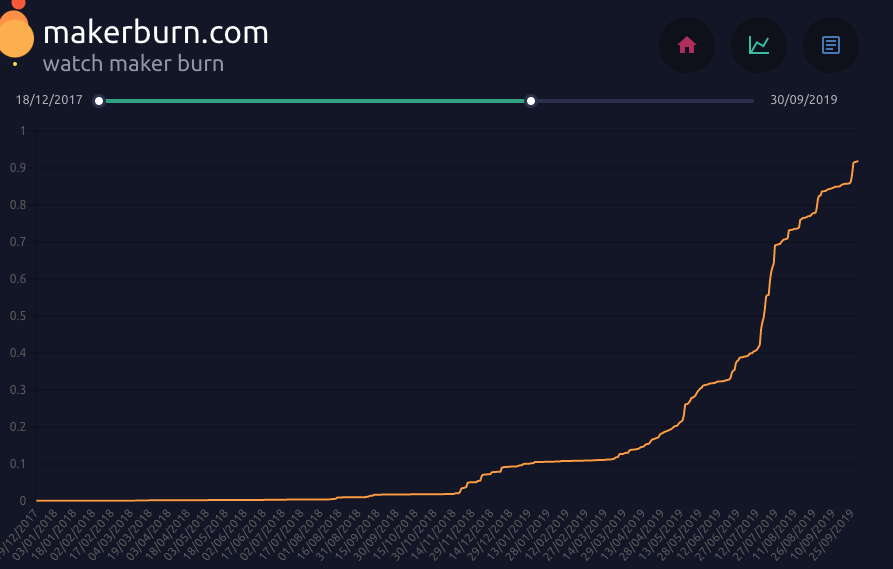

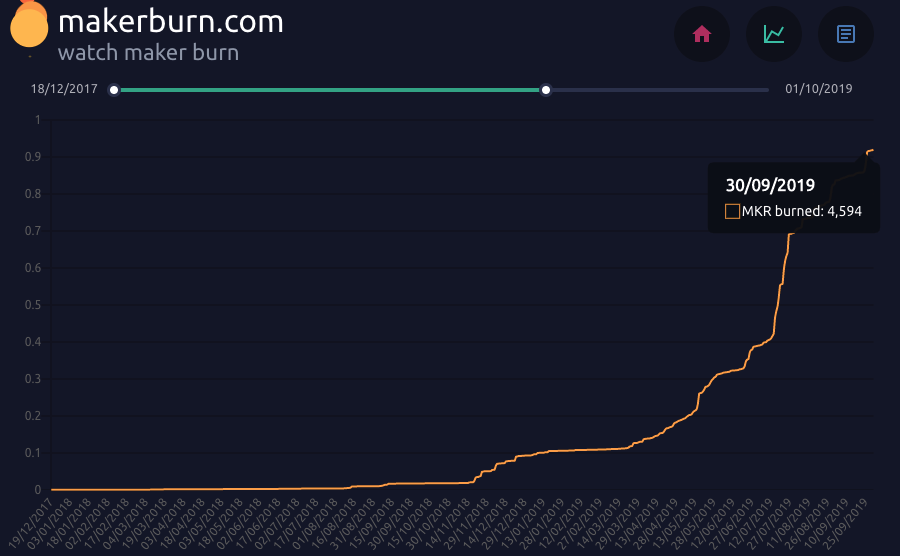

In [12]:
dune_mkr_burned.tail()

,debt_payment,date_trunc,usd_fee_paid,mkr_burned,avg_MKR_price,cumsum_mkr_burned
date_trunc,,,,,,
2019-09-26,1.515115e+06,2019-09-26T00:00:00Z,64257.311824,143.057969,449.169749,4568.185311
2019-09-27,6.366783e+05,2019-09-27T00:00:00Z,7214.430099,16.168397,446.205650,4584.353708
2019-09-28,1.452062e+05,2019-09-28T00:00:00Z,492.589362,1.095010,449.849141,4585.448718
2019-09-29,1.699335e+05,2019-09-29T00:00:00Z,2581.404125,5.920057,436.043784,4591.368775
2019-09-30,1.920636e+05,2019-09-30T00:00:00Z,1250.943840,2.890272,432.811853,4594.259047


We notice there's a missing day in the Dune dataset, but as we'll see in the Bloxy data, the amount of DAI burnt on that day was 0. So it makes sense.

In [29]:
dune_mkr_burned.asfreq('D')[dune_mkr_burned.asfreq('D').isna().all(axis=1)]

,debt_payment,date_trunc,usd_fee_paid,mkr_burned,avg_MKR_price,cumsum_mkr_burned
date_trunc,,,,,,
2017-12-26,NaN,NaN,NaN,NaN,NaN,NaN


# Bloxy data: DAI mints and burns

The Dune dataset does not contain all DAI burns - only those associated with wipes and shuts of CDPs, not those associated with busts at the liquidation engine. The Bloxy dataset contains all burns. We'll assume the difference between the two to be relative to the DAI burns from liquidated CDPs.

Quick look at records and data types

In [15]:
bloxy_dai = pd.read_csv('raw_files/dai_minted_burnt.csv')
display(bloxy_dai.head())
display(bloxy_dai.dtypes)

,__timestamp,Minted DAI,Burnt DAI,Total Supply
0,2020-08-16,5.106168e+08,5.020074e+08,8.609317e+06
1,2020-08-15,5.106161e+08,5.020057e+08,8.610394e+06
2,2020-08-14,5.106154e+08,5.019819e+08,8.633486e+06
3,2020-08-02,5.106144e+08,5.019690e+08,8.645420e+06
4,2020-08-01,5.106035e+08,5.019584e+08,8.645149e+06


__timestamp      object
Minted DAI      float64
Burnt DAI       float64
Total Supply    float64
dtype: object

Set date as index

In [56]:
bloxy_dai.set_index(pd.to_datetime(bloxy_dai['__timestamp']).dt.date, 
                    verify_integrity=True,
                    inplace=True,
                   )
bloxy_dai.sort_index(inplace=True)

Total burnt DAI must be less than total minted DAI

In [55]:
(bloxy_dai['Burnt DAI']<=bloxy_dai['Minted DAI']).all()

True

Compute daily mints and burns.

In [30]:
bloxy_dai['daily_dai_mint'] = bloxy_dai['Minted DAI'].diff().fillna(bloxy_dai['Minted DAI'])
bloxy_dai['daily_dai_burn'] = bloxy_dai['Burnt DAI'].diff().fillna(bloxy_dai['Burnt DAI'])
display(bloxy_dai.head())

,__timestamp,Minted DAI,Burnt DAI,Total Supply,daily_dai_mint,daily_dai_burn
__timestamp,,,,,,
2017-12-18,2017-12-18,5.953420e+05,4.594384e+01,5.952961e+05,5.953420e+05,45.943840
2017-12-19,2017-12-19,1.975174e+06,3.544043e+04,1.939733e+06,1.379832e+06,35394.482980
2017-12-20,2017-12-20,4.651557e+06,5.376922e+05,4.113865e+06,2.676383e+06,502251.750000
2017-12-21,2017-12-21,5.456912e+06,5.874749e+05,4.869437e+06,8.053550e+05,49782.711992
2017-12-22,2017-12-22,5.771463e+06,1.334928e+06,4.436535e+06,3.145512e+05,747453.127687


Check days with zero burns as a sanity check for the missing day in the Dune dataset

In [31]:
bloxy_dai.query('daily_dai_burn==0')

,__timestamp,Minted DAI,Burnt DAI,Total Supply,daily_dai_mint,daily_dai_burn
__timestamp,,,,,,
2017-12-26,2017-12-26,7.579563e+06,1.401506e+06,6.178057e+06,205450.0,0.0


Since the Dune dataset only contains a subset of the burns, the daily burns in the Bloxy dataset should always be larger than or equal to the debt payments in the Dune dataset (we allow for 0.1% margin of error)

In [53]:
dai_burns = dune_mkr_burned.join(bloxy_dai)[['debt_payment','daily_dai_burn']]
(dai_burns['debt_payment']/dai_burns['daily_dai_burn'] -1 <= 0.001).all()

True

# Bloxy data: ETH locked

Quick look at records and data types

In [58]:
bloxy_eth = pd.read_csv('raw_files/dai_weth.csv')
display(bloxy_eth.head())
display(bloxy_eth.dtypes)

,__timestamp,Locked Amount,Accumulated Lock,Accumulated Free
0,2019-03-18,2.214632e+06,3.758154e+06,1.543522e+06
1,2019-04-10,2.214461e+06,3.955065e+06,1.740604e+06
2,2019-03-19,2.214044e+06,3.764668e+06,1.550624e+06
3,2019-03-17,2.212164e+06,3.754520e+06,1.542356e+06
4,2019-03-20,2.211088e+06,3.767672e+06,1.556584e+06


__timestamp          object
Locked Amount       float64
Accumulated Lock    float64
Accumulated Free    float64
dtype: object

Set date as index

In [59]:
bloxy_eth.set_index(pd.to_datetime(bloxy_eth['__timestamp']).dt.date, 
                    verify_integrity=True,
                    inplace=True,
                   )
bloxy_eth.sort_index(inplace=True)

Accumulated locks must be less than accumulated frees

In [61]:
(bloxy_eth['Accumulated Lock']>=bloxy_eth['Accumulated Free']).all()

True

Locked amount can be derived from locks and frees

In [77]:
(abs((bloxy_eth['Accumulated Lock']-bloxy_eth['Accumulated Free'])/bloxy_eth['Locked Amount'] - 1)<0.001).all()

True

We then plot the Locked Amount and compare it to the plot from mkr.tools

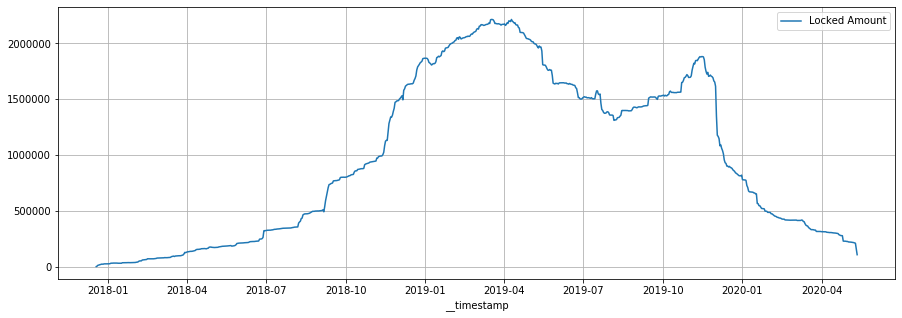

In [81]:
bloxy_eth.plot(y='Locked Amount', figsize=(15,5), grid=True)

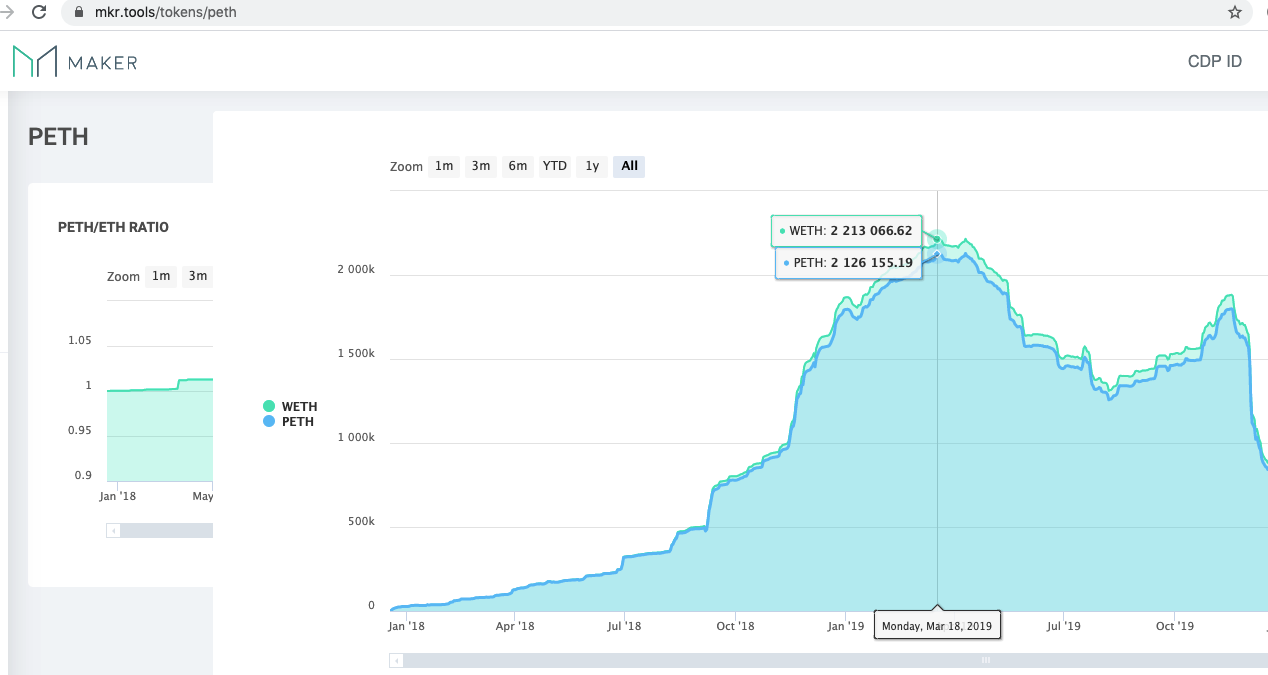

We check the max value of locked amount to double check that it refers to WETH and not PETH. It's close to what we see in mkr.tools.

In [82]:
bloxy_eth['Locked Amount'].max()

2214631.8815223174

# ETH price
Our model of the "debt price" will require the value in USD of the locked collateral in Maker.

Quick look at records and data types

In [91]:
eth_price = pd.read_csv('raw_files/DAIETH_data.csv', usecols=['date','ETH Price', 'Stability Fee'])
display(eth_price.head())
display(eth_price.dtypes)

,date,ETH Price,Stability Fee
0,2017-12-18,736.004090,0.5
1,2017-12-19,832.236972,0.5
2,2017-12-20,810.287507,0.5
3,2017-12-21,837.231080,0.5
4,2017-12-22,689.014990,0.5


date              object
ETH Price        float64
Stability Fee    float64
dtype: object

Set date as index, compare price plot to coinmarketcap's

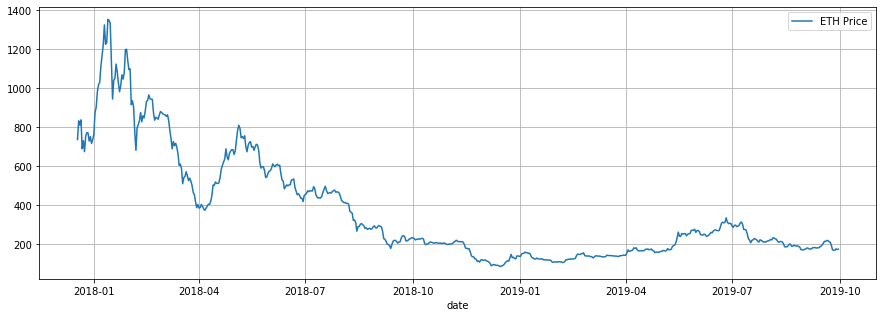

In [92]:
eth_price.set_index(pd.to_datetime(eth_price['date']).dt.date, 
                    verify_integrity=True,
                    inplace=True,
                   )
eth_price.sort_index(inplace=True)
eth_price.plot(y='ETH Price', figsize=(15,5), grid=True)

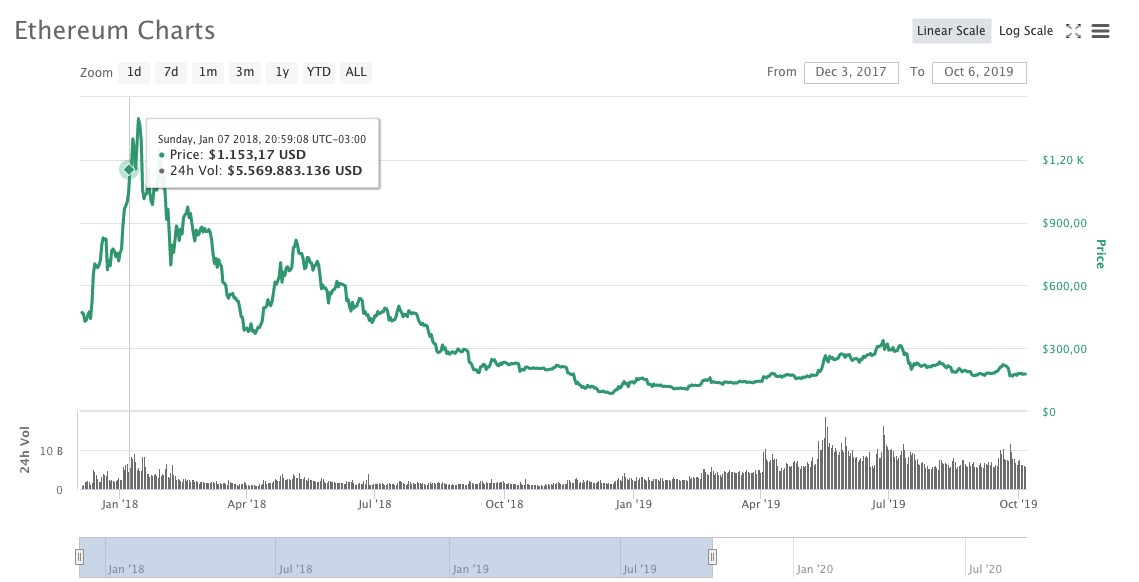

Plot stability fee, compare to mkr.tools

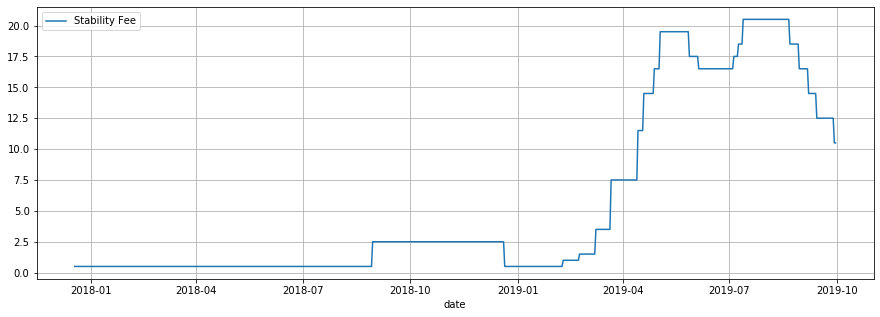

In [93]:
eth_price.plot(y='Stability Fee', figsize=(15,5), grid=True)

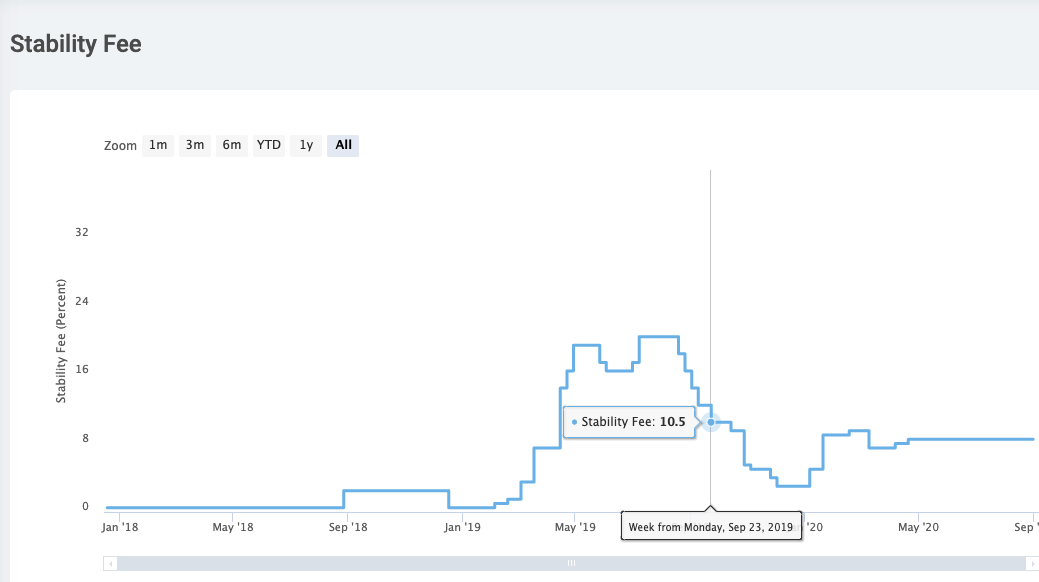